# Transferlearning 9 class - add new image - random split
https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50?select=resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

In [58]:
!pip3 install opencv-python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os

In [2]:
# Fixed classes
NUM_CLASSES = 9
CHANNELS = 3

IMAGE_RESIZE = 48
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [3]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [60]:
# import sys
# sys.path.append('/root/.local/lib/python3.5/site-packages')

In [74]:
#get the weight form github repo
# !git clone https://github.com/sunh0003/W251_FinalProject

Cloning into 'W251_FinalProject'...
remote: Enumerating objects: 42, done.
remote: Total 42 (delta 0), reused 0 (delta 0), pack-reused 42
Unpacking objects: 100% (42/42), done.
Checking connectivity... done.


In [4]:
resnet_weights_path = '/notebooks/W251_FinalProject/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
#Still not talking about our train/test data or any pre-processing.
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 9)                 18441     
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________


In [7]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [8]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
image_size = IMAGE_RESIZE

train_dir = "/notebooks/data9cls_newimg_randomsplit/train/"
valid_dir = "/notebooks/data9cls_newimg_randomsplit/validation/"

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        valid_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Using TensorFlow backend.


Found 30124 images belonging to 9 classes.
Found 7392 images belonging to 9 classes.


In [9]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 302, 100, 74)

In [10]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/notebooks/W251_FinalProject/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [11]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights('/notebooks/W251_FinalProject/best.hdf5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
302/302 [==============================] - 265s 877ms/step - loss: 2.1212 - acc: 0.3203 - val_loss: 2.5423 - val_acc: 0.2875
Epoch 2/10
302/302 [==============================] - 257s 850ms/step - loss: 1.9587 - acc: 0.3674 - val_loss: 2.1235 - val_acc: 0.3490
Epoch 3/10
302/302 [==============================] - 254s 842ms/step - loss: 1.9201 - acc: 0.3756 - val_loss: 2.1486 - val_acc: 0.3551
Epoch 4/10
302/302 [==============================] - 259s 857ms/step - loss: 1.9231 - acc: 0.3803 - val_loss: 2.1130 - val_acc: 0.3686
Epoch 5/10
302/302 [==============================] - 255s 843ms/step - loss: 1.8936 - acc: 0.3865 - val_loss: 2.3251 - val_acc: 0.3405
Epoch 6/10
302/302 [==============================] - 255s 844ms/step - loss: 1.9049 - acc: 0.3896 - val_loss: 2.1813 - val_acc: 0.3458
Epoch 7/10
302/302 [==============================] - 257s 851ms/step - loss: 1.9032 - acc: 0.3910 - val_loss: 2.1170 - val_acc: 0.3620


In [12]:
print(fit_history.history.keys())

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


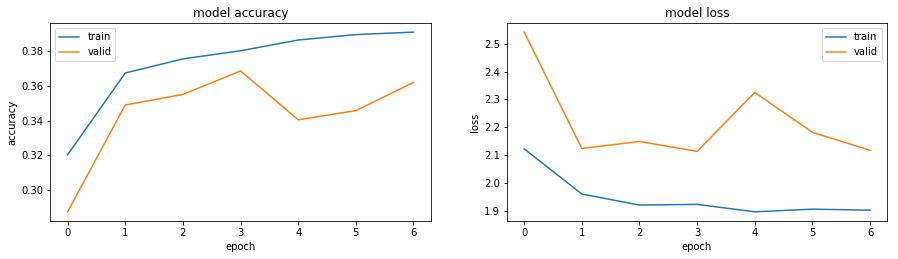

In [13]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [17]:
test_generator = data_generator.flow_from_directory(
    directory = '/notebooks/data9cls_newimg_randomsplit/validation',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 7392 images belonging to 9 classes.


In [81]:
# test_generator.reset()

# pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

# predicted_class_indices = np.argmax(pred, axis = 1)

# confusion matrix

Found 7392 images belonging to 9 classes.
Confusion Matrix
[[232   0   3   6  95 177 195 180  72]
 [  3 128   0  11   6  10   3   0   1]
 [ 15   0  14   0  14  14  28  16  10]
 [  0  11   0 141   0   6   4   2   0]
 [138   4   0   4 205 156 183 199 129]
 [203   1   0   6 140 875 251 256  93]
 [112   0   0   4  96 266 438 218  82]
 [131   0   2   3 165 220 225 344  49]
 [ 74   1   3   1  85 107 117  61 348]]
Classification Report
              precision    recall  f1-score   support

       angry       0.26      0.24      0.25       960
    confused       0.88      0.79      0.83       162
     disgust       0.64      0.13      0.21       111
  distracted       0.80      0.86      0.83       164
        fear       0.25      0.20      0.22      1018
       happy       0.48      0.48      0.48      1825
     neutral       0.30      0.36      0.33      1216
         sad       0.27      0.30      0.28      1139
    surprise       0.44      0.44      0.44       797

    accuracy             

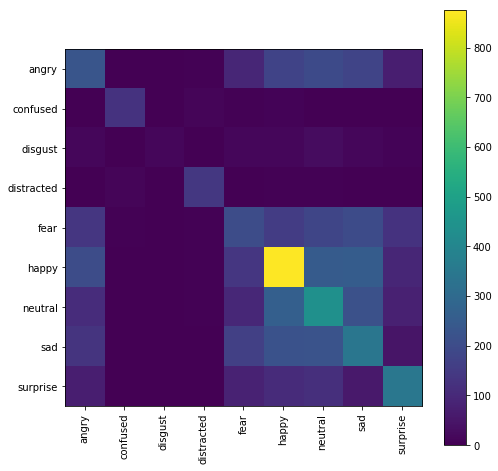

In [20]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Found 30124 images belonging to 9 classes.
# Found 7392 images belonging to 9 classes.
nb_train_samples = 30124
nb_validation_samples = 7392
batch_size=BATCH_SIZE_TESTING
# We need to recreate our validation generator with shuffle = false
validation_generator = data_generator.flow_from_directory(
        directory = '/notebooks/data9cls_newimg_randomsplit/validation',
        #color_mode = 'grayscale',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TESTING,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [ ]:
# def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
#     cm = cm.astype('float') / cm.sum(axis=1)#[:, np.newaxis]
#     plt.figure(figsize=(10,10))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

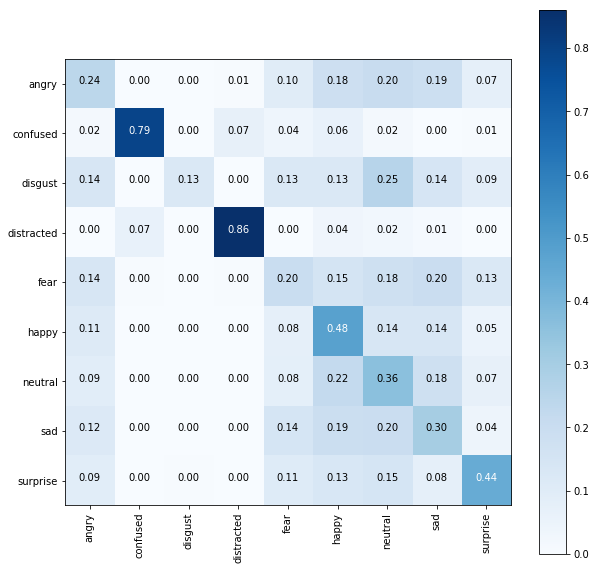

In [35]:
import itertools
cm=cnf_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:,None]
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")